# Data Analysis
This notebook performs several vital steps:
1. Preliminary Data Analysis
2. Data Cleaning
3. Data Normalization
4. Data Augmentation
5. Data Projection ... ?
6. Sensor Fusion
7. Exploration

Dataset Overview
- **Data Type**: IMU sensor readings (accelerometer + gyroscope)
- **Format**: JSON files with session-based structure
- **Sample Rate**: 40 Hz
- **Sensor Placement**: Sternum
- **Labels**: Phase (top/bottom) and Posture (full-rom/partial-rom)

In [103]:
# Import necessary libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import glob

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Preliminary Data Analysis

Load data.

In [104]:
# Load all JSON files from the raw dataset directory, but only want files collected from 12/04/25
data_files = glob.glob('dataset_raw/*.json')
print(f"Found {len(data_files)} data files")

# Function to load and parse JSON data
def load_json_data(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Load all files
all_data = [load_json_data(f) for f in data_files]
print(f"Loaded {len(all_data)} files successfully")

Found 16 data files
Loaded 16 files successfully


Convert to a dataframe.

In [105]:
# Convert all sessions to a unified DataFrame
def extract_sessions(data_dict, file_index, filename):
    sessions = []
    for session in data_dict['sessions']:
        # Create unique session ID by combining file index and original session ID
        unique_session_id = f"{file_index}_{session['session_id']}"
        
        # Extract session metadata
        session_info = {
            'unique_session_id': unique_session_id,
            'original_session_id': session['session_id'],
            'file_index': file_index,
            'filename': filename,
            # 'timestamp': session['timestamp'],
            # 'participant_id': session.get('participant_id', ''),
            'imu_placement': session.get('imu_placement', ''),
            # 'phase_label': session.get('phase_label', ''),
            'posture_label': session.get('posture_label', ''),
            'sample_count': session['sample_count'],
            # 'duration_sec': session['duration_sec']
        }
        
        # Extract sensor data with sample index
        for sample_idx, data_point in enumerate(session['data']):
            row = session_info.copy()
            row.update({
                'sample_index': sample_idx,  # Use sample index instead of elapsed_sec
                'time_sec': sample_idx / 40.0,  # Calculate time from sample index (40 Hz)
                'ax': data_point['ax'],
                'ay': data_point['ay'],
                'az': data_point['az'],
                'gx': data_point['gx'],
                'gy': data_point['gy'],
                'gz': data_point['gz']
            })
            sessions.append(row)
    return sessions

# Extract all sessions from all files with unique IDs
all_sessions = []
for file_idx, (data, filename) in enumerate(zip(all_data, data_files)):
    all_sessions.extend(extract_sessions(data, file_idx, Path(filename).name))

# Create DataFrame
df = pd.DataFrame(all_sessions)
print(f"Total data points: {len(df)}")
print(f"\nDataFrame shape: {df.shape}")
print(f"Unique sessions: {df['unique_session_id'].nunique()}")
df

Total data points: 22880

DataFrame shape: (22880, 15)
Unique sessions: 277


,unique_session_id,original_session_id,file_index,filename,imu_placement,posture_label,sample_count,sample_index,time_sec,ax,ay,az,gx,gy,gz
0,0_0,0,0,pushup_data_20251204_181925.json,Sternum,good-form,84,0,0.000,0.376953,0.188721,0.946533,1.740458,-0.908397,6.748092
1,0_0,0,0,pushup_data_20251204_181925.json,Sternum,good-form,84,1,0.025,0.379150,0.216553,1.035156,10.534351,-3.022901,4.885496
2,0_0,0,0,pushup_data_20251204_181925.json,Sternum,good-form,84,2,0.050,0.334717,0.197510,0.992676,21.931297,-3.687023,1.625954
3,0_0,0,0,pushup_data_20251204_181925.json,Sternum,good-form,84,3,0.075,0.333496,0.234619,0.918701,25.595419,4.610687,0.984733
4,0_0,0,0,pushup_data_20251204_181925.json,Sternum,good-form,84,4,0.100,0.349609,0.203857,0.828369,28.076336,3.381679,0.183206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22875,15_14,14,15,pushup_data_20251204_182238.json,Sternum,good-form,77,72,1.800,0.329102,-0.048584,0.853760,8.755725,5.580153,0.458015
22876,15_14,14,15,pushup_data_20251204_182238.json,Sternum,good-form,77,73,1.825,0.402832,-0.012695,0.732178,0.709924,13.160305,3.694656
22877,15_14,14,15,pushup_data_20251204_182238.json,Sternum,good-form,77,74,1.850,0.434814,0.064209,0.898926,3.083969,-2.625954,1.847328
22878,15_14,14,15,pushup_data_20251204_182238.json,Sternum,good-form,77,75,1.875,0.336182,-0.003906,1.064209,4.305344,-13.427481,-0.961832


Basic stats.

In [88]:
# Count unique sessions
unique_sessions = df.groupby(['timestamp', 'unique_session_id']).size().reset_index(name='count')
print(f"Total unique sessions: {len(unique_sessions)}")

# Label distribution
print("\nPhase Label Distribution:")
print(df.groupby('phase_label')['unique_session_id'].nunique())

print("\nPosture Label Distribution:")
print(df.groupby('posture_label')['unique_session_id'].nunique())

Total unique sessions: 277

Phase Label Distribution:
phase_label
top    277
Name: unique_session_id, dtype: int64

Posture Label Distribution:
posture_label
good-form       155
hips-high        41
hips-sagging     40
partial-rom      41
Name: unique_session_id, dtype: int64


## 2. Data Cleaning

User high pass filter for gyroscope data, and low pass filter for accelerometer data

In [106]:
from scipy.signal import butter, filtfilt
import os

# -------------------------------------------------------------
# FILTER FUNCTIONS
# -------------------------------------------------------------
def butter_lowpass(cutoff, fs, order=4):
    return butter(order, cutoff / (0.5 * fs), btype='low')

def butter_highpass(cutoff, fs, order=4):
    return butter(order, cutoff / (0.5 * fs), btype='high')

def lowpass(data, cutoff=10, fs=40):
    b, a = butter_lowpass(cutoff, fs)
    return filtfilt(b, a, data, axis=0)

def highpass(data, cutoff=0.2, fs=40):
    b, a = butter_highpass(cutoff, fs)
    return filtfilt(b, a, data, axis=0)

## 3. Data Normalization

In [107]:
import os
import json
import numpy as np
from scipy.signal import butter, filtfilt, medfilt

# -------------------------------------------------------------
# FILTER FUNCTIONS
# -------------------------------------------------------------
def butter_lowpass(cutoff, fs, order=4):
    return butter(order, cutoff / (0.5 * fs), btype='low')

def butter_highpass(cutoff, fs, order=4):
    return butter(order, cutoff / (0.5 * fs), btype='high')

def apply_lowpass(data, cutoff=10, fs=40):
    """Low-pass filter for accelerometer."""
    b, a = butter_lowpass(cutoff, fs)
    return filtfilt(b, a, data, axis=0)

def apply_highpass(data, cutoff=0.2, fs=40):
    """High-pass filter for gyroscope."""
    b, a = butter_highpass(cutoff, fs)
    return filtfilt(b, a, data, axis=0)

def estimate_gravity(data, cutoff=0.5, fs=40):
    """Gravity from very-low-frequency accelerometer."""
    b, a = butter_lowpass(cutoff, fs)
    return filtfilt(b, a, data, axis=0)

def apply_median_filter(data, kernel=3):
    """Median filter to remove spikes."""
    return medfilt(data, kernel_size=(kernel, 1))

# -------------------------------------------------------------
# PROCESS SINGLE JSON FILE (FILTERING ONLY, NO NORMALIZATION)
# -------------------------------------------------------------
def process_file(filepath, start_session_id, accel_mean=None, accel_std=None,
                 gyro_mean=None, gyro_std=None, compute_norm_stats=False):

    with open(filepath, "r") as f:
        raw = json.load(f)

    fs = raw["metadata"]["sample_rate_hz"]
    new_sessions = []
    next_id = start_session_id

    for session in raw["sessions"]:

        # ----------- RAW → MATRIX 6-CHANNEL --------------------
        rows = []
        for d in session["data"]:
            rows.append([d["ax"], d["ay"], d["az"], d["gx"], d["gy"], d["gz"]])
        rows = np.array(rows)

        accel = rows[:, 0:3]
        gyro  = rows[:, 3:6]

        # ----------- 1) MEDIAN FILTER (DENOISING) --------------
        accel_med = apply_median_filter(accel, kernel=3)
        gyro_med  = apply_median_filter(gyro, kernel=3)

        # ----------- 2) ACCEL LOW-PASS (10 Hz) -----------------
        accel_lp = apply_lowpass(accel_med, cutoff=10, fs=fs)

        # ----------- 3) GYRO HIGH-PASS (DRIFT REMOVAL) ---------
        gyro_hp = apply_highpass(gyro_med, cutoff=0.2, fs=fs)

        # ----------- 4) GRAVITY SEPARATION ----------------------
        gravity = estimate_gravity(accel_lp, cutoff=0.5, fs=fs)
        linear_accel = accel_lp - gravity  # (3-axis motion only)

        # ----------- 5) COMPUTE NORMALIZATION STATS (BUT DON'T APPLY YET) ----
        if compute_norm_stats:
            # Collect stats during first pass
            if accel_mean is None:
                accel_mean = linear_accel.mean(axis=0)
                accel_std  = linear_accel.std(axis=0)
                gyro_mean  = gyro_hp.mean(axis=0)
                gyro_std   = gyro_hp.std(axis=0)
            else:
                # accumulate (simple averaging approach)
                accel_mean = (accel_mean + linear_accel.mean(axis=0)) / 2
                accel_std  = (accel_std  + linear_accel.std(axis=0)) / 2
                gyro_mean  = (gyro_mean  + gyro_hp.mean(axis=0)) / 2
                gyro_std   = (gyro_std   + gyro_hp.std(axis=0)) / 2

        # NO NORMALIZATION APPLIED - keep filtered data as-is
        linear_accel_clean = linear_accel
        gyro_clean = gyro_hp

        # ----------- 6) REBUILD SESSION JSON -------------------
        filt_data = []
        for i, d in enumerate(session["data"]):
            filt_data.append({
                "timestamp": d["timestamp"],
                "elapsed_sec": d["elapsed_sec"],
                "ax": float(linear_accel_clean[i, 0]),
                "ay": float(linear_accel_clean[i, 1]),
                "az": float(linear_accel_clean[i, 2]),
                "gx": float(gyro_clean[i, 0]),
                "gy": float(gyro_clean[i, 1]),
                "gz": float(gyro_clean[i, 2]),
            })

        new_sessions.append({
            "session_id": next_id,
            # "timestamp": session["timestamp"],
            # "participant_id": session.get("participant_id", ""),
            "imu_placement": session.get("imu_placement", ""),
            # "notes": session.get("notes", ""),
            # "phase_label": session.get("phase_label"),
            "posture_label": session.get("posture_label"),
            "sample_count": len(filt_data),
            "sample_rate_hz": fs,
            "data": filt_data
        })

        next_id += 1

    return new_sessions, next_id, accel_mean, accel_std, gyro_mean, gyro_std


# -------------------------------------------------------------
# PROCESS FOLDER → FILTERED OUTPUT (NO NORMALIZATION YET)
# -------------------------------------------------------------
def process_folder(folder_path, output_path):
    files = [f for f in os.listdir(folder_path) if f.endswith(".json")]
    files = sorted(files)

    all_sessions = []
    session_id = 0

    # First pass: compute normalization statistics from filtered data
    accel_mean = accel_std = gyro_mean = gyro_std = None
    for fname in files:
        fp = os.path.join(folder_path, fname)
        _, session_id, accel_mean, accel_std, gyro_mean, gyro_std = process_file(
            fp, session_id,
            accel_mean, accel_std, gyro_mean, gyro_std,
            compute_norm_stats=True
        )

    # Second pass: process without normalization
    session_id = 0
    final_sessions = []
    for fname in files:
        fp = os.path.join(folder_path, fname)
        sessions, session_id, _, _, _, _ = process_file(
            fp, session_id,
            accel_mean, accel_std, gyro_mean, gyro_std,
            compute_norm_stats=False
        )
        final_sessions.extend(sessions)

    # Build final JSON with normalization stats saved but NOT applied
    output = {
        "metadata": {
            "sample_rate_hz": 40,
            "format_version": "2.0",
            "total_sessions": len(final_sessions),
            "normalization": {
                "accel_mean": accel_mean.tolist(),
                "accel_std": accel_std.tolist(),
                "gyro_mean": gyro_mean.tolist(),
                "gyro_std": gyro_std.tolist()
            },
            "normalized": False  # Data is NOT normalized yet
        },
        "sessions": final_sessions
    }

    with open(output_path, "w") as f:
        json.dump(output, f, indent=2)

    print(f"Saved filtered dataset (NOT normalized) → {output_path}")
    print(f"Total sessions: {len(final_sessions)}")
    print(f"Normalization stats saved in metadata (to be applied after augmentation)")


# -------------------------------------------------------------
# Example Usage:
process_folder("dataset_raw", "dataset_clean/merged_dataset.json")
# -------------------------------------------------------------


Saved filtered dataset (NOT normalized) → dataset_clean/merged_dataset.json
Total sessions: 277
Normalization stats saved in metadata (to be applied after augmentation)


Run this to generate graphs.

Visualizing session 0


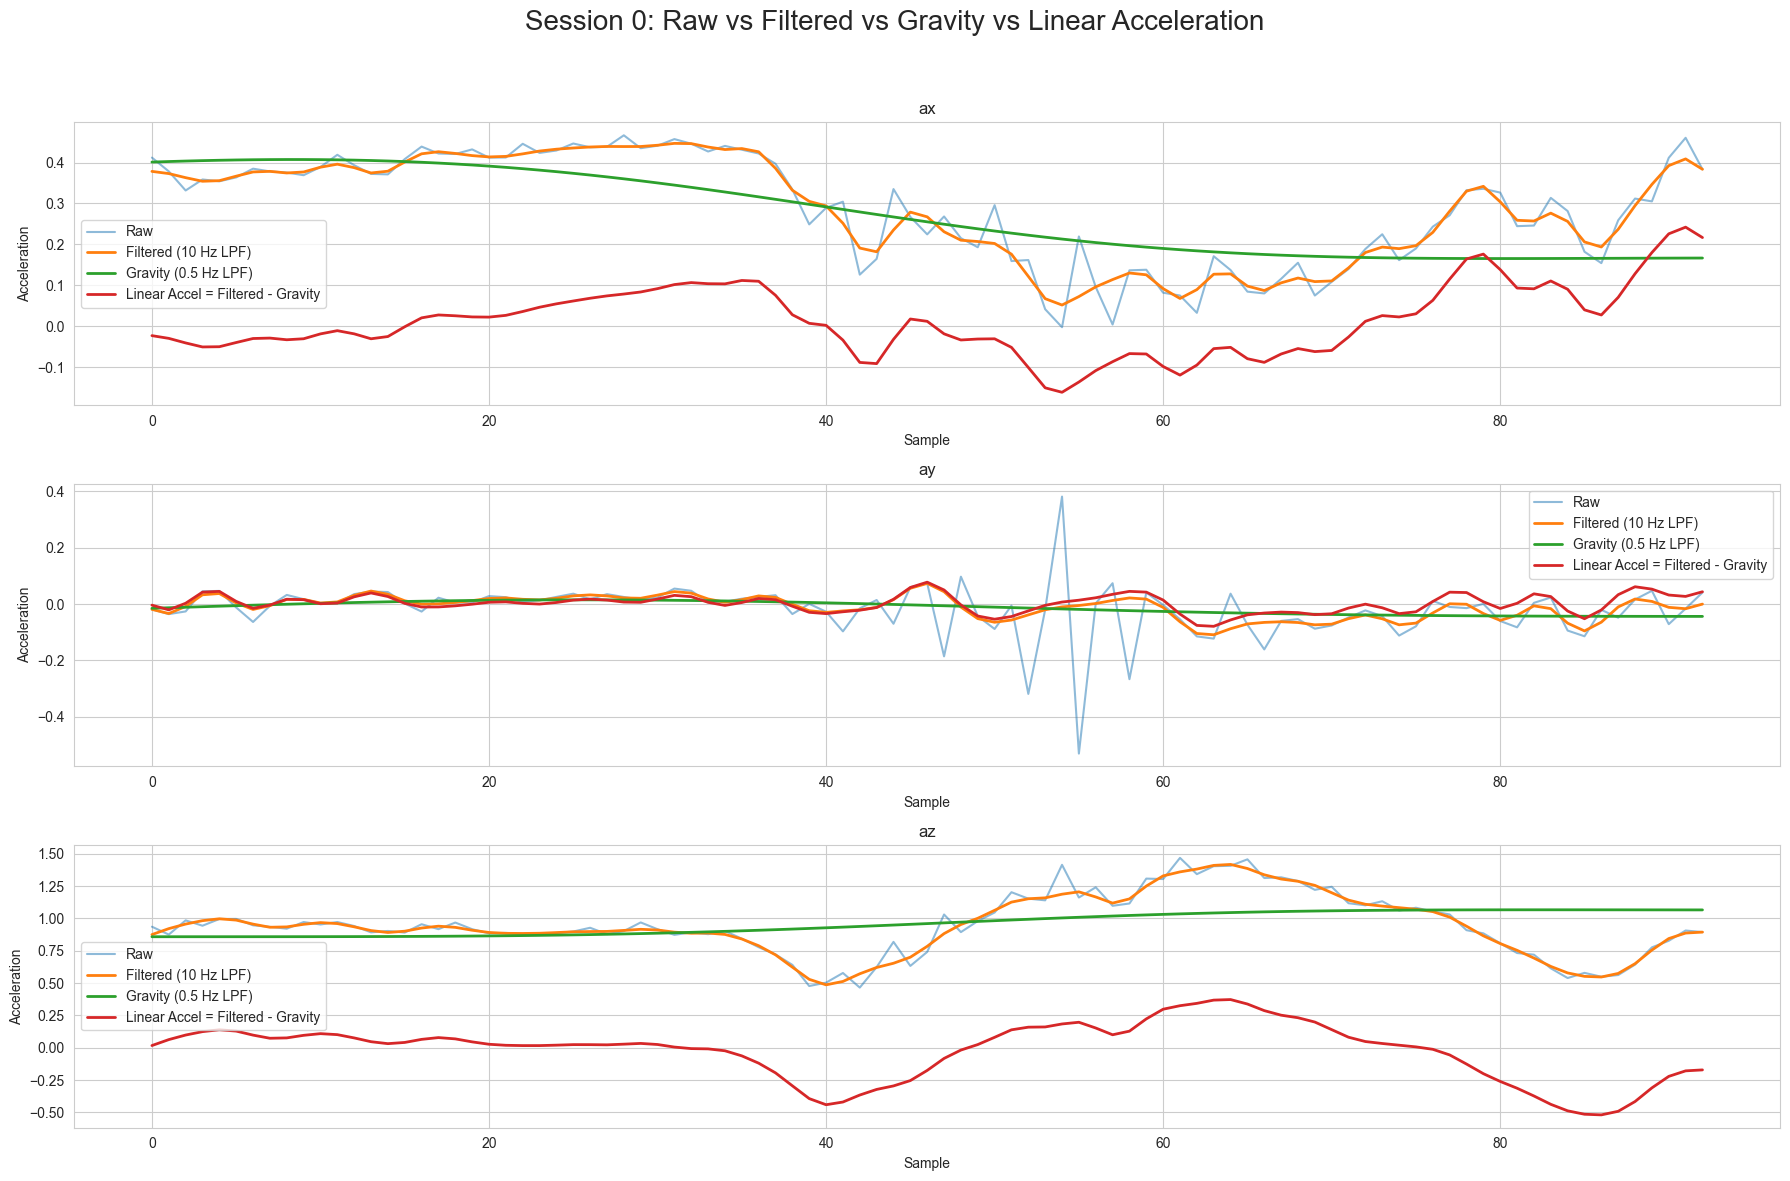

In [108]:
import json
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import butter, filtfilt, medfilt

# -------------------------------------------------------------
# FILTER FUNCTIONS
# -------------------------------------------------------------
def butter_lowpass(cutoff, fs, order=4):
    return butter(order, cutoff / (0.5 * fs), btype="low")

def butter_highpass(cutoff, fs, order=4):
    return butter(order, cutoff / (0.5 * fs), btype="high")

def apply_lowpass(data, cutoff, fs):
    b, a = butter_lowpass(cutoff, fs)
    return filtfilt(b, a, data, axis=0)

def estimate_gravity(data, cutoff, fs):
    b, a = butter_lowpass(cutoff, fs)
    return filtfilt(b, a, data, axis=0)

def apply_median(data, k=3):
    return medfilt(data, kernel_size=(k,1))

# -------------------------------------------------------------
# LOAD MERGED JSON
# -------------------------------------------------------------
dataset_path = "dataset_raw/pushup_data_20251204_181709.json"  # <-- change this to your actual path

with open(dataset_path, "r") as f:
    merged = json.load(f)

sessions = merged["sessions"]
fs = merged["metadata"]["sample_rate_hz"]

# -------------------------------------------------------------
# PICK RANDOM SESSION
# -------------------------------------------------------------
session = sessions[0]
print(f"Visualizing session {session['session_id']}")

# Extract accel only
raw = np.array([[d["ax"], d["ay"], d["az"]] for d in session["data"]])

# -------------------------------------------------------------
# PROCESS ACCEL: MEDIAN → LPF → GRAVITY → LINEAR
# -------------------------------------------------------------
raw_med = apply_median(raw, k=3)

accel_filt = apply_lowpass(raw_med, cutoff=10, fs=fs)
gravity     = estimate_gravity(accel_filt, cutoff=0.5, fs=fs)
linear_acc  = accel_filt - gravity

# -------------------------------------------------------------
# PLOT EVERYTHING
# -------------------------------------------------------------
axes = ["ax", "ay", "az"]

plt.figure(figsize=(18, 12))
plt.suptitle(f"Session {session['session_id']}: Raw vs Filtered vs Gravity vs Linear Acceleration", fontsize=20)

for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(raw[:, i], label="Raw", alpha=0.5)
    plt.plot(accel_filt[:, i], label="Filtered (10 Hz LPF)", linewidth=2)
    plt.plot(gravity[:, i], label="Gravity (0.5 Hz LPF)", linewidth=2)
    plt.plot(linear_acc[:, i], label="Linear Accel = Filtered - Gravity", linewidth=2)
    
    plt.title(axes[i])
    plt.xlabel("Sample")
    plt.ylabel("Acceleration")
    plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Data Augmentation

In [109]:
import json
import numpy as np
import random
import scipy.interpolate as interp

# ------------------
# Load dataset
# ------------------
with open("dataset_clean/merged_dataset.json", "r") as f:
    raw = json.load(f)

sessions = raw["sessions"]

# Convert session data to numpy array
def session_to_array(session):
    return np.array([[d["ax"], d["ay"], d["az"],
                      d["gx"], d["gy"], d["gz"]] for d in session["data"]])

# ---- Group by class label ----
LABEL_KEY = "posture_label"  
class_to_samples = {}

for sess in sessions:
    label = sess[LABEL_KEY]
    arr = session_to_array(sess)
    class_to_samples.setdefault(label, []).append(sess)

print("Classes found:", class_to_samples.keys())


Classes found: dict_keys(['good-form', 'hips-sagging', 'hips-high', 'partial-rom'])


Augmentation functions

In [110]:
# ---------- JITTER ----------
def augment_jitter(x, sigma=0.01):
    return x + np.random.normal(0, sigma, x.shape)

# ---------- SCALING ----------
def augment_scaling(x, sigma=0.1):
    factor = np.random.normal(1.0, sigma, (1, x.shape[1]))
    return x * factor

# ---------- TIME MASK ----------
def augment_time_mask(x, max_mask_ratio=0.15):
    T = x.shape[0]
    mask_len = int(T * max_mask_ratio)
    start = np.random.randint(0, T-mask_len)
    x_aug = x.copy()
    x_aug[start:start+mask_len] = 0
    return x_aug

# ---------- TIME WARP ----------
def augment_time_warp(x, sigma=0.2):
    T = x.shape[0]
    orig_time = np.arange(T)
    factor = np.random.uniform(1-sigma, 1+sigma)
    new_time = np.linspace(0, T-1, int(T*factor))

    x_interp = np.zeros((len(new_time), x.shape[1]))
    for i in range(x.shape[1]):
        f = interp.interp1d(orig_time, x[:, i], fill_value="extrapolate")
        x_interp[:, i] = f(new_time)

    return x_interp

# ---------- MAGNITUDE WARP ----------
def augment_magnitude_warp(x, sigma=0.2, knot=4):
    T = x.shape[0]
    orig = np.arange(T)
    random_factors = np.random.normal(1.0, sigma, knot)
    knot_points = np.linspace(0, T-1, knot)
    warp_curve = interp.interp1d(knot_points, random_factors, kind='cubic')(orig)
    return x * warp_curve[:, None]

# ---------- ROTATION ----------
def random_rotation_matrix():
    theta = np.random.uniform(0, np.pi*2)
    phi = np.random.uniform(0, np.pi*2)
    z = np.random.uniform(0, 1)
    qw = np.sqrt(1-z) * np.sin(theta)
    qx = np.sqrt(1-z) * np.cos(theta)
    qy = np.sqrt(z) * np.sin(phi)
    qz = np.sqrt(z) * np.cos(phi)

    R = np.array([
        [1 - 2*(qy*qy + qz*qz), 2*(qx*qy - qz*qw), 2*(qx*qz + qy*qw)],
        [2*(qx*qy + qz*qw), 1 - 2*(qx*qx + qz*qz), 2*(qy*qz - qx*qw)],
        [2*(qx*qz - qy*qw), 2*(qy*qz + qx*qw), 1 - 2*(qx*qx + qy*qy)]
    ])
    return R

def augment_rotate(x):
    R = random_rotation_matrix()
    acc = x[:, :3]
    gyro = x[:, 3:]
    acc_rot = acc @ R.T
    gyro_rot = gyro @ R.T
    return np.concatenate([acc_rot, gyro_rot], axis=1)


Preserve original format

In [111]:
def array_to_session(arr, base_session, session_id):
    """Convert Nx6 numpy array back into full JSON session."""
    
    sample_rate = base_session["sample_rate_hz"]
    dt = 1.0 / sample_rate

    new_data = []
    timestamp0 = datetime.now().isoformat()

    for i, row in enumerate(arr):
        new_data.append({
            "timestamp": timestamp0,
            "elapsed_sec": i * dt,
            "ax": float(row[0]),
            "ay": float(row[1]),
            "az": float(row[2]),
            "gx": float(row[3]),
            "gy": float(row[4]),
            "gz": float(row[5]),
        })

    return {
        "session_id": session_id,
        # "timestamp": timestamp0,
        # "participant_id": base_session.get("participant_id", ""),s
        "imu_placement": base_session.get("imu_placement", ""),
        "notes": "augmented",
        LABEL_KEY: base_session[LABEL_KEY],
        "sample_count": len(arr),
        "duration_sec": len(arr) * dt,
        "sample_rate_hz": sample_rate,
        "data": new_data
    }


Random augmentation sampler

In [112]:
def generate_augmented_json(class_to_samples, target_per_class=200):
    augmented_sessions = []
    session_counter = 10_000  # new unique IDs start here

    ops = [
        augment_jitter,
        augment_scaling,
        augment_rotate,
        augment_magnitude_warp,
        augment_time_mask,
        augment_time_warp
    ]

    for label, original_sessions in class_to_samples.items():
        print(f"Generating for class '{label}'...")

        # Add original raw sessions first
        for sess in original_sessions:
            augmented_sessions.append(sess)

        # Create augmentations
        while len([s for s in augmented_sessions if s[LABEL_KEY] == label]) < target_per_class:
            base = random.choice(original_sessions)
            arr_raw = session_to_array(base)
            aug_func = random.choice(ops)
            arr_aug = aug_func(arr_raw)

            new_session = array_to_session(
                arr_aug,
                base_session=base,
                session_id=session_counter
            )
            session_counter += 1

            augmented_sessions.append(new_session)

    return augmented_sessions


Generate balanced dataset

In [113]:
aug_sessions = generate_augmented_json(
    class_to_samples,
    target_per_class=300   # <-- change as needed
)

out_json = {
    "metadata": raw["metadata"],
    "sessions": aug_sessions
}

with open("dataset_clean/augmented_pushups.json", "w") as f:
    json.dump(out_json, f, indent=2)

print("Saved augmented dataset with", len(aug_sessions), "sessions.")


Generating for class 'good-form'...
Generating for class 'hips-sagging'...
Generating for class 'hips-high'...
Generating for class 'partial-rom'...
Saved augmented dataset with 1200 sessions.


Apply normalization to augmented data

In [114]:
import json
import numpy as np

# Load the augmented dataset
with open("dataset_clean/augmented_pushups.json", "r") as f:
    aug_data = json.load(f)

# Extract normalization stats from metadata (computed from raw data)
norm_stats = aug_data["metadata"]["normalization"]
accel_mean = np.array(norm_stats["accel_mean"])
accel_std = np.array(norm_stats["accel_std"])
gyro_mean = np.array(norm_stats["gyro_mean"])
gyro_std = np.array(norm_stats["gyro_std"])

print("Normalization statistics (from raw data):")
print(f"  Accel mean: {accel_mean}")
print(f"  Accel std:  {accel_std}")
print(f"  Gyro mean:  {gyro_mean}")
print(f"  Gyro std:   {gyro_std}")

# Apply normalization to all sessions
normalized_sessions = []
for session in aug_data["sessions"]:
    # Extract data as numpy array
    data_array = np.array([
        [d["ax"], d["ay"], d["az"], d["gx"], d["gy"], d["gz"]]
        for d in session["data"]
    ])
    
    # Separate accel and gyro
    accel = data_array[:, :3]
    gyro = data_array[:, 3:]
    
    # Apply normalization
    accel_norm = (accel - accel_mean) / accel_std
    gyro_norm = (gyro - gyro_mean) / gyro_std
    
    # Rebuild session data with normalized values
    normalized_data = []
    for i, d in enumerate(session["data"]):
        normalized_data.append({
            "timestamp": d["timestamp"],
            "elapsed_sec": d["elapsed_sec"],
            "ax": float(accel_norm[i, 0]),
            "ay": float(accel_norm[i, 1]),
            "az": float(accel_norm[i, 2]),
            "gx": float(gyro_norm[i, 0]),
            "gy": float(gyro_norm[i, 1]),
            "gz": float(gyro_norm[i, 2]),
        })
    
    # Create normalized session
    normalized_session = session.copy()
    normalized_session["data"] = normalized_data
    normalized_sessions.append(normalized_session)

# Update metadata to indicate data is now normalized
aug_data["metadata"]["normalized"] = True
aug_data["sessions"] = normalized_sessions

# Save normalized augmented dataset
with open("dataset_clean/augmented_normalized_pushups.json", "w") as f:
    json.dump(aug_data, f, indent=2)

print(f"\nSaved normalized augmented dataset → dataset_clean/augmented_normalized_pushups.json")
print(f"Total sessions: {len(normalized_sessions)}")
print(f"Normalization applied using stats from raw data before augmentation")

Normalization statistics (from raw data):
  Accel mean: [ 0.00042208 -0.00188804 -0.00668184]
  Accel std:  [0.09626791 0.04948182 0.20323046]
  Gyro mean:  [-0.73875794  1.9212489  -0.94398156]
  Gyro std:   [ 7.33304658 27.609867    5.87350077]

Saved normalized augmented dataset → dataset_clean/augmented_normalized_pushups.json
Total sessions: 1200
Normalization applied using stats from raw data before augmentation


Data Augmentation data analsysis

Total sessions: 1200

Sessions per class:
  good-form: 300
  hips-sagging: 300
  hips-high: 300
  partial-rom: 300

Average sample length: 79.04916666666666
Min length: 44
Max length: 135

Visualizing session with label: hips-high


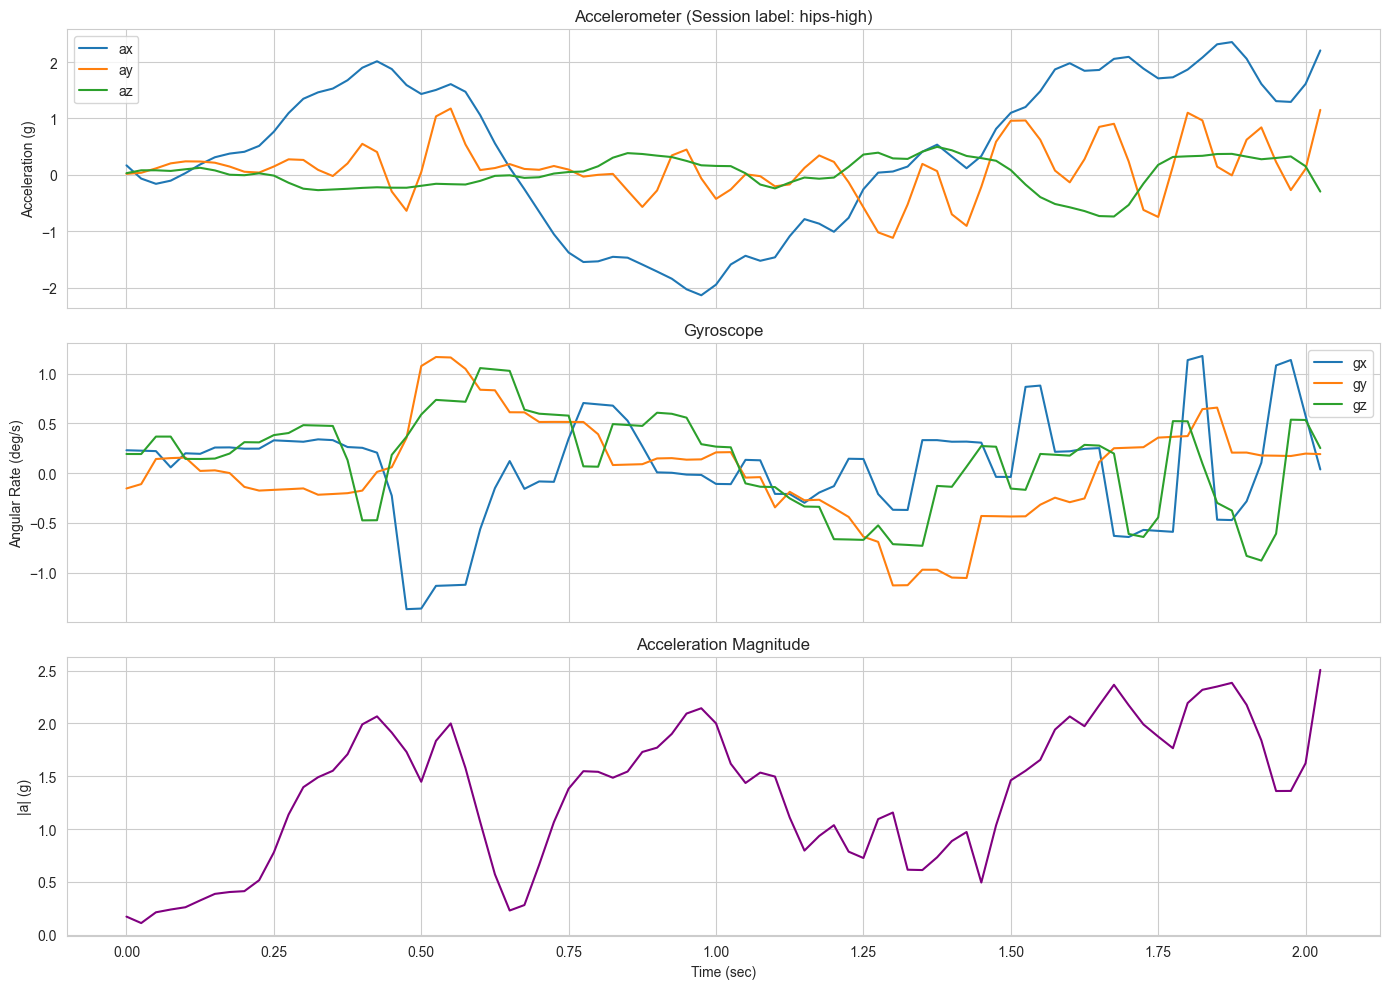


Acceleration Stats (ax, ay, az):
  Mean: [0.4342437  0.11227079 0.02325021]
  Std: [1.31887353 0.47940372 0.28277847]
  Min: [-2.13605681 -1.11766731 -0.73904572]
  Max: [2.3549848  1.17587419 0.49648307]

Gyroscope Stats (gx, gy, gz):
  Mean: [0.04860385 0.02776896 0.12031028]
  Std: [0.5134498  0.49240085 0.46798147]
  Min: [-1.36678237 -1.12820987 -0.87869356]
  Max: [1.17711856 1.16670932 1.05542945]


In [115]:
import json
import numpy as np
import matplotlib.pyplot as plt
import random

# ---------------------------
# LOAD AUGMENTED JSON
# ---------------------------
with open("dataset_clean/augmented_normalized_pushups.json", "r") as f:
    data = json.load(f)

sessions = data["sessions"]
print(f"Total sessions: {len(sessions)}")

# determine class key (posture_label or phase_label)
class_key = "posture_label"
if class_key not in sessions[0]:
    class_key = "phase_label"

# ---------------------------
# BASIC ANALYSIS
# ---------------------------

# Count sessions per class
class_counts = {}
lengths = []
for s in sessions:
    label = s[class_key]
    class_counts[label] = class_counts.get(label, 0) + 1
    lengths.append(s["sample_count"])

print("\nSessions per class:")
for k, v in class_counts.items():
    print(f"  {k}: {v}")

print("\nAverage sample length:", np.mean(lengths))
print("Min length:", np.min(lengths))
print("Max length:", np.max(lengths))

# ---------------------------
# SELECT A RANDOM SAMPLE FOR VISUALIZATION
# ---------------------------
sample = random.choice(sessions)
label = sample[class_key]
print("\nVisualizing session with label:", label)

# Extract time-series array
arr = np.array([
    [d["ax"], d["ay"], d["az"], d["gx"], d["gy"], d["gz"]]
    for d in sample["data"]
])

# Time axis
t = np.array([d["elapsed_sec"] for d in sample["data"]])

# ---------------------------
# PLOTTING
# ---------------------------

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Accelerometer
axes[0].plot(t, arr[:,0], label="ax")
axes[0].plot(t, arr[:,1], label="ay")
axes[0].plot(t, arr[:,2], label="az")
axes[0].set_title(f"Accelerometer (Session label: {label})")
axes[0].set_ylabel("Acceleration (g)")
axes[0].legend()

# Gyroscope
axes[1].plot(t, arr[:,3], label="gx")
axes[1].plot(t, arr[:,4], label="gy")
axes[1].plot(t, arr[:,5], label="gz")
axes[1].set_title("Gyroscope")
axes[1].set_ylabel("Angular Rate (deg/s)")
axes[1].legend()

# Acc magnitude
acc_mag = np.linalg.norm(arr[:, :3], axis=1)
axes[2].plot(t, acc_mag, color="purple")
axes[2].set_title("Acceleration Magnitude")
axes[2].set_xlabel("Time (sec)")
axes[2].set_ylabel("|a| (g)")

plt.tight_layout()
plt.show()

# ---------------------------
# OPTIONAL: PRINT SUMMARY STATS
# ---------------------------
print("\nAcceleration Stats (ax, ay, az):")
print("  Mean:", np.mean(arr[:, :3], axis=0))
print("  Std:", np.std(arr[:, :3], axis=0))
print("  Min:", np.min(arr[:, :3], axis=0))
print("  Max:", np.max(arr[:, :3], axis=0))

print("\nGyroscope Stats (gx, gy, gz):")
print("  Mean:", np.mean(arr[:, 3:], axis=0))
print("  Std:", np.std(arr[:, 3:], axis=0))
print("  Min:", np.min(arr[:, 3:], axis=0))
print("  Max:", np.max(arr[:, 3:], axis=0))


## 4. Data Visualization

In [131]:
# --------------------------
# Load JSON dataset
# --------------------------
json_path = "dataset_clean/augmented_normalized_pushups.json"   # or your original dataset
with open(json_path, "r") as f:
    raw = json.load(f)

sessions = raw["sessions"]

# --------------------------
# Extract each IMU sample row into a flat structure
# --------------------------
all_sessions = []

for file_idx, sess in enumerate(sessions):
    session_id = sess.get("session_id", file_idx)
    label = sess.get("posture_label", sess.get("phase_label", None))
    placement = sess.get("imu_placement", "")
    participant = sess.get("participant_id", "")
    sample_rate = sess.get("sample_rate_hz", None)
    timestamp = sess.get("timestamp", None)

    for i, d in enumerate(sess["data"]):
        all_sessions.append({
            "unique_session_id": f"{session_id}",
            "row_in_session": i,
            "participant_id": participant,
            "timestamp": timestamp,
            "imu_placement": placement,
            "label": label,
            "sample_rate_hz": sample_rate,
            "elapsed_sec": d.get("elapsed_sec"),
            "ax": d.get("ax"),
            "ay": d.get("ay"),
            "az": d.get("az"),
            "gx": d.get("gx"),
            "gy": d.get("gy"),
            "gz": d.get("gz"),
        })

# --------------------------
# Create DataFrame
# --------------------------
df = pd.DataFrame(all_sessions)

print(f"Total data points: {len(df)}")
print(f"DataFrame shape: {df.shape}")
print(f"Unique sessions: {df['unique_session_id'].nunique()}")

df.head()

Total data points: 94859
DataFrame shape: (94859, 14)
Unique sessions: 1200


,unique_session_id,row_in_session,participant_id,timestamp,imu_placement,label,sample_rate_hz,elapsed_sec,ax,ay,az,gx,gy,gz
0,0,0,,None,Sternum,good-form,40,2.302915,-0.240979,-0.038923,0.114541,0.544678,-0.337015,-0.105447
1,0,1,,None,Sternum,good-form,40,2.302930,-0.310149,-0.376486,0.340954,0.551133,-0.355403,-0.081087
2,0,2,,None,Sternum,good-form,40,2.302939,-0.426075,0.096603,0.514340,0.408489,-0.363830,-0.069583
3,0,3,,None,Sternum,good-form,40,2.302947,-0.527795,0.892773,0.643618,0.414457,-0.196679,-0.096935
4,0,4,,None,Sternum,good-form,40,2.302954,-0.522104,0.947138,0.714698,1.148855,-0.203414,-0.078671


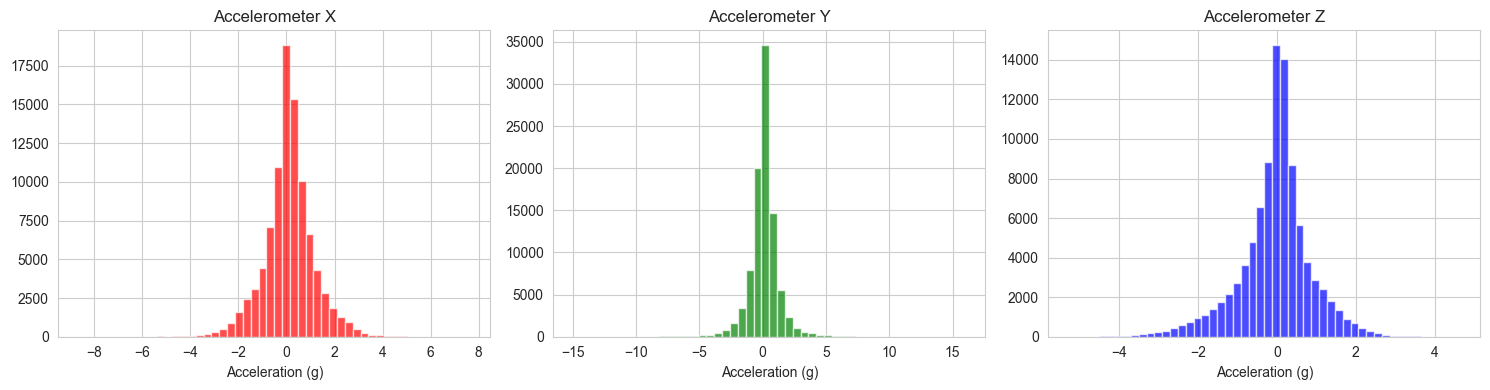

In [132]:
# Plot accelerometer data distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df['ax'], bins=50, alpha=0.7, color='red')
axes[0].set_title('Accelerometer X')
axes[0].set_xlabel('Acceleration (g)')

axes[1].hist(df['ay'], bins=50, alpha=0.7, color='green')
axes[1].set_title('Accelerometer Y')
axes[1].set_xlabel('Acceleration (g)')

axes[2].hist(df['az'], bins=50, alpha=0.7, color='blue')
axes[2].set_title('Accelerometer Z')
axes[2].set_xlabel('Acceleration (g)')

plt.tight_layout()
plt.show()

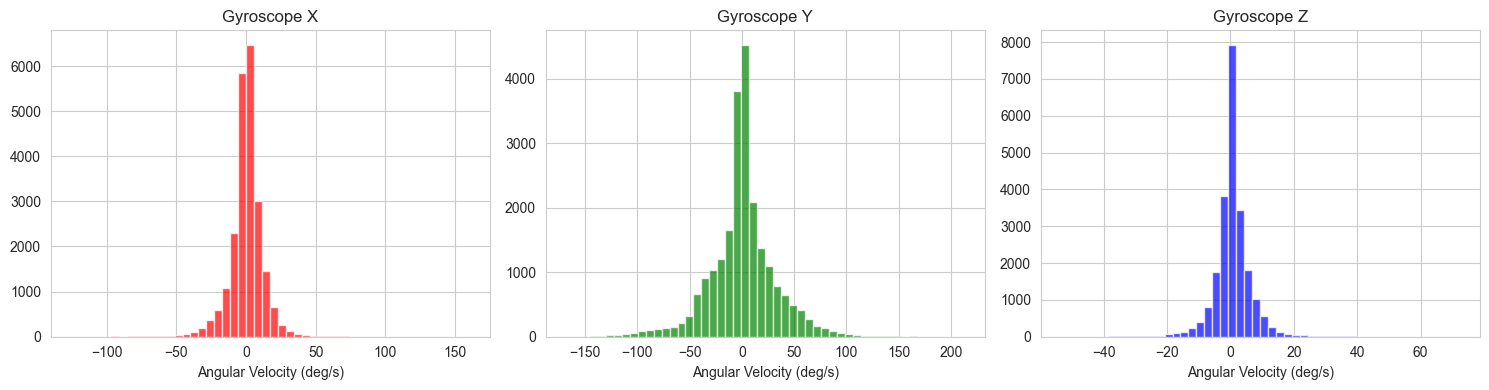

In [12]:
# Plot gyroscope data distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df['gx'], bins=50, alpha=0.7, color='red')
axes[0].set_title('Gyroscope X')
axes[0].set_xlabel('Angular Velocity (deg/s)')

axes[1].hist(df['gy'], bins=50, alpha=0.7, color='green')
axes[1].set_title('Gyroscope Y')
axes[1].set_xlabel('Angular Velocity (deg/s)')

axes[2].hist(df['gz'], bins=50, alpha=0.7, color='blue')
axes[2].set_title('Gyroscope Z')
axes[2].set_xlabel('Angular Velocity (deg/s)')

plt.tight_layout()
plt.show()

## 5. Sample Session Analysis

Visualizing session: 0, label = good-form


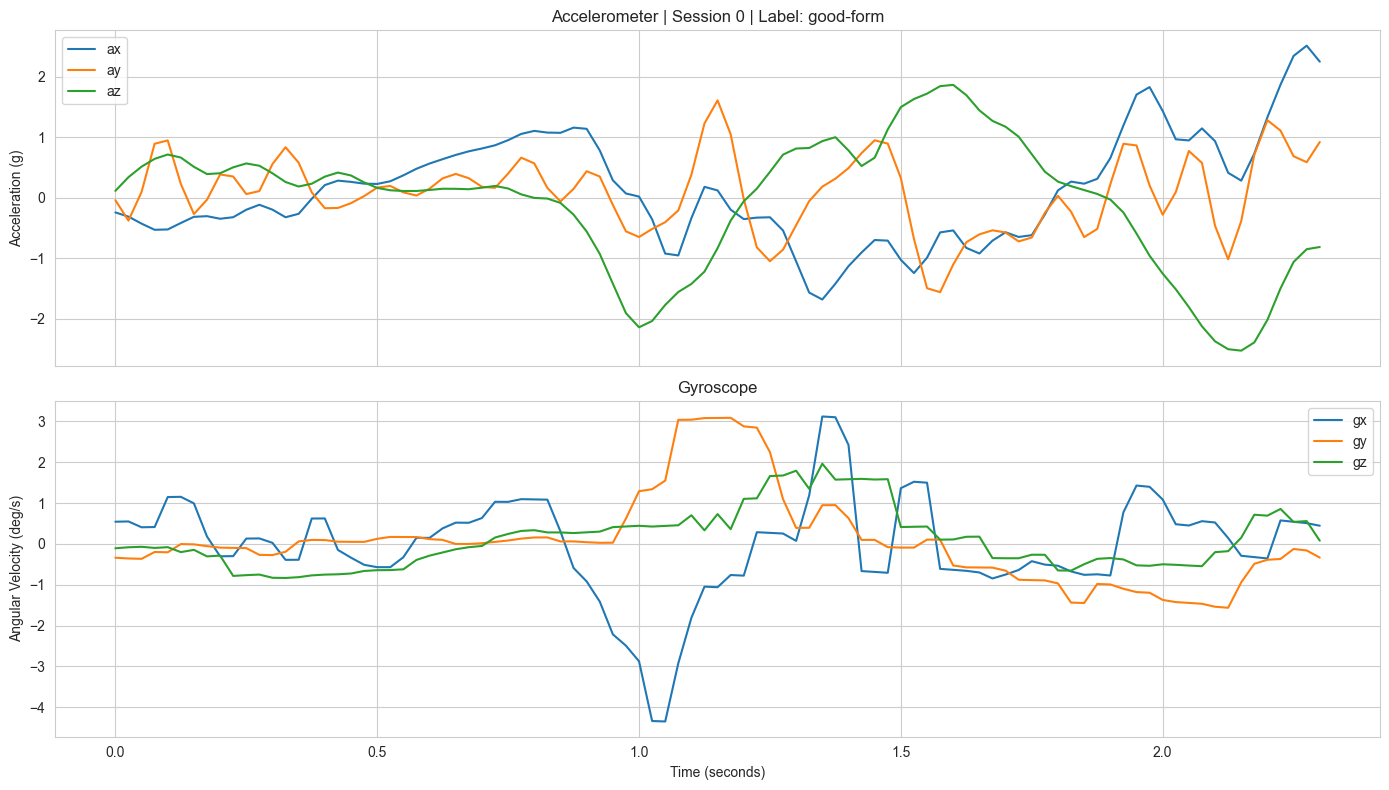

In [144]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -----------------------------------------
# Select a sample session
# -----------------------------------------
session_id = df["unique_session_id"].iloc[0]  # change to any session you want
session_df = df[df["unique_session_id"] == session_id].reset_index(drop=True)

print(f"Visualizing session: {session_id}, label = {session_df['label'].iloc[0]}")

# -----------------------------------------
# Construct time axis: sample_index / 40Hz
# -----------------------------------------
sample_rate = 40.0
time_axis = np.arange(len(session_df)) / sample_rate

# -----------------------------------------
# Plot accelerometer & gyroscope signals
# -----------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# --- Accelerometer ---
axes[0].plot(time_axis, session_df["ax"], label="ax")
axes[0].plot(time_axis, session_df["ay"], label="ay")
axes[0].plot(time_axis, session_df["az"], label="az")
axes[0].set_title(f"Accelerometer | Session {session_id} | Label: {session_df['label'].iloc[0]}")
axes[0].set_ylabel("Acceleration (g)")
axes[0].legend()
axes[0].grid(True)

# --- Gyroscope ---
axes[1].plot(time_axis, session_df["gx"], label="gx")
axes[1].plot(time_axis, session_df["gy"], label="gy")
axes[1].plot(time_axis, session_df["gz"], label="gz")
axes[1].set_title("Gyroscope")
axes[1].set_xlabel("Time (seconds)")
axes[1].set_ylabel("Angular Velocity (deg/s)")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


## 6. Compare Different Labels

KeyError: 'phase_label'

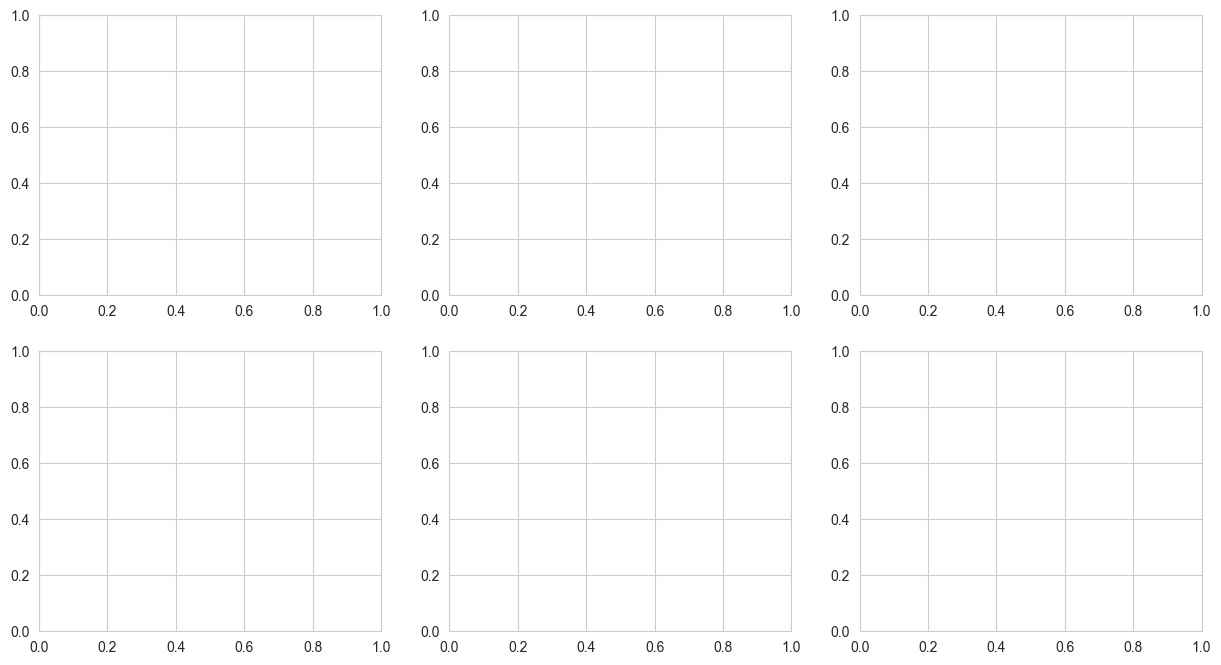

In [145]:
# Compare phase labels (top vs bottom)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for phase in df['phase_label'].unique():
    if pd.notna(phase) and phase != '':
        phase_data = df[df['phase_label'] == phase]
        
        # Accelerometer
        axes[0, 0].hist(phase_data['ax'], bins=30, alpha=0.5, label=phase)
        axes[0, 1].hist(phase_data['ay'], bins=30, alpha=0.5, label=phase)
        axes[0, 2].hist(phase_data['az'], bins=30, alpha=0.5, label=phase)
        
        # Gyroscope
        axes[1, 0].hist(phase_data['gx'], bins=30, alpha=0.5, label=phase)
        axes[1, 1].hist(phase_data['gy'], bins=30, alpha=0.5, label=phase)
        axes[1, 2].hist(phase_data['gz'], bins=30, alpha=0.5, label=phase)

axes[0, 0].set_title('Accel X by Phase')
axes[0, 1].set_title('Accel Y by Phase')
axes[0, 2].set_title('Accel Z by Phase')
axes[1, 0].set_title('Gyro X by Phase')
axes[1, 1].set_title('Gyro Y by Phase')
axes[1, 2].set_title('Gyro Z by Phase')

for ax in axes.flat:
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

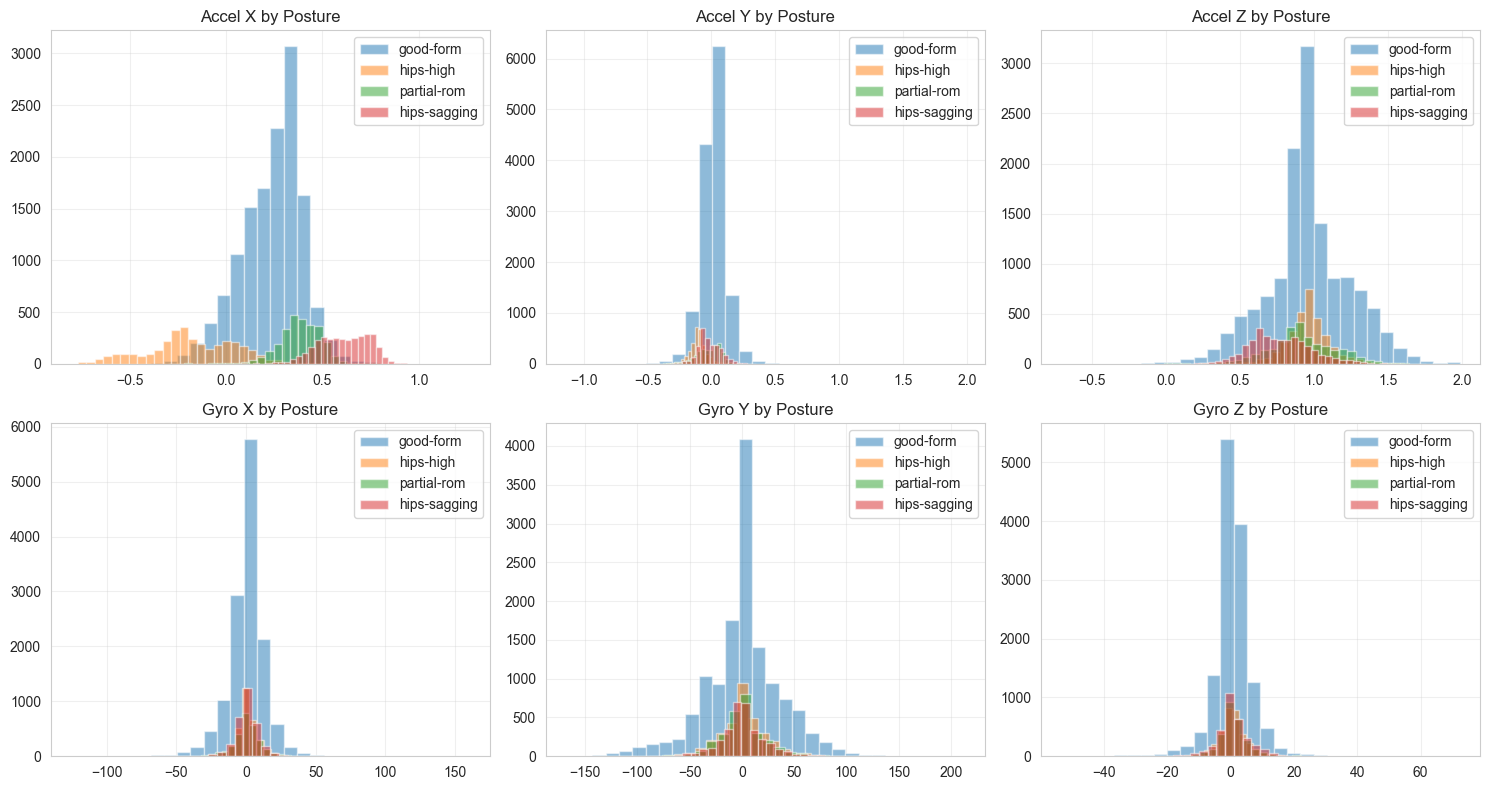

In [15]:
# Compare posture labels (full-rom vs partial-rom)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for posture in df['posture_label'].unique():
    if pd.notna(posture) and posture != '':
        posture_data = df[df['posture_label'] == posture]
        
        # Accelerometer
        axes[0, 0].hist(posture_data['ax'], bins=30, alpha=0.5, label=posture)
        axes[0, 1].hist(posture_data['ay'], bins=30, alpha=0.5, label=posture)
        axes[0, 2].hist(posture_data['az'], bins=30, alpha=0.5, label=posture)
        
        # Gyroscope
        axes[1, 0].hist(posture_data['gx'], bins=30, alpha=0.5, label=posture)
        axes[1, 1].hist(posture_data['gy'], bins=30, alpha=0.5, label=posture)
        axes[1, 2].hist(posture_data['gz'], bins=30, alpha=0.5, label=posture)

axes[0, 0].set_title('Accel X by Posture')
axes[0, 1].set_title('Accel Y by Posture')
axes[0, 2].set_title('Accel Z by Posture')
axes[1, 0].set_title('Gyro X by Posture')
axes[1, 1].set_title('Gyro Y by Posture')
axes[1, 2].set_title('Gyro Z by Posture')

for ax in axes.flat:
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Correlation Analysis

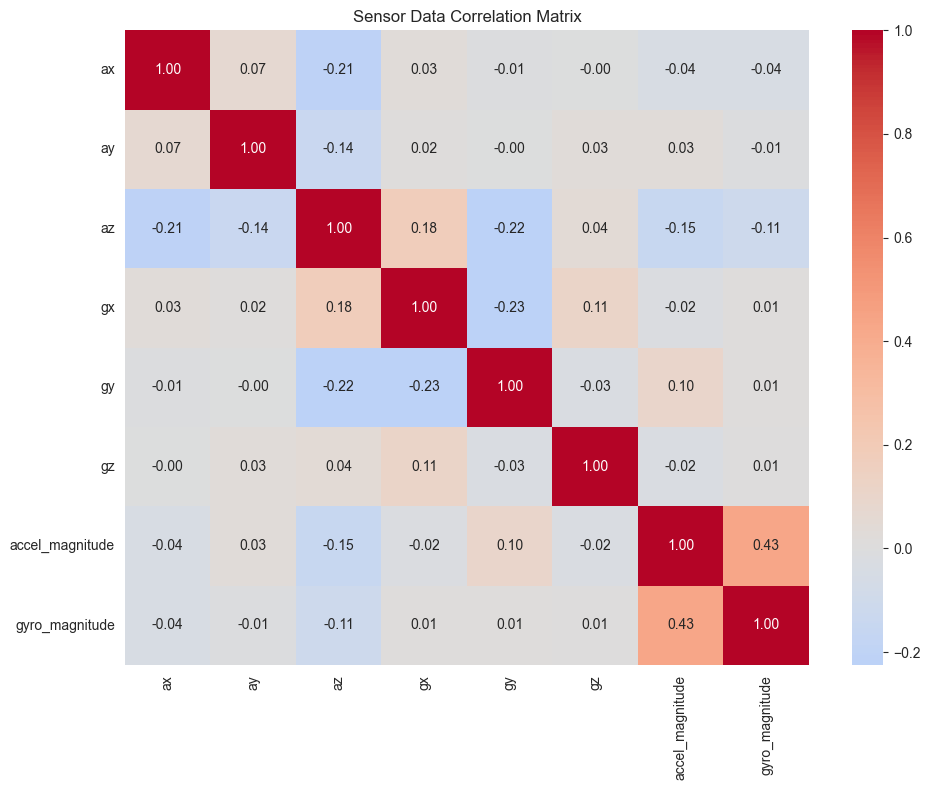

In [147]:
# Compute correlation matrix
sensor_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'accel_magnitude', 'gyro_magnitude']
corr_matrix = df[sensor_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Sensor Data Correlation Matrix')
plt.tight_layout()
plt.show()

## 10. Data Quality Checks

In [149]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print("\n" + "="*50 + "\n")

# Check for outliers (values beyond 3 standard deviations)
print("Potential Outliers (beyond 3 std):")
for col in ['ax', 'ay', 'az', 'gx', 'gy', 'gz']:
    mean = df[col].mean()
    std = df[col].std()
    outliers = df[(df[col] < mean - 3*std) | (df[col] > mean + 3*std)]
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.2f}%)")

Missing Values:
unique_session_id        0
row_in_session           0
participant_id           0
timestamp            94859
imu_placement            0
label                    0
sample_rate_hz           0
elapsed_sec              0
ax                       0
ay                       0
az                       0
gx                       0
gy                       0
gz                       0
accel_magnitude          0
gyro_magnitude           0
dtype: int64


Potential Outliers (beyond 3 std):
ax: 998 outliers (1.05%)
ay: 1901 outliers (2.00%)
az: 1144 outliers (1.21%)
gx: 1751 outliers (1.85%)
gy: 1788 outliers (1.88%)
gz: 1993 outliers (2.10%)


## 11. Export Summary
Save the processed data for further analysis or model training.

In [20]:
# Save processed DataFrame
# df.to_csv('processed_pushup_data.csv', index=False)
# print("Processed data saved to 'processed_pushup_data.csv'")

# Save session statistics
# session_stats.to_csv('session_statistics.csv', index=False)
# print("Session statistics saved to 'session_statistics.csv'")

## 12. 3D Position Tracking via Double Integration

Integrate accelerometer data twice to estimate the 3D position of the chest during push-ups.

**IMPORTANT**: Position tracking requires data in **physical units (g)**, not normalized dimensionless values. We'll use the filtered but non-normalized dataset from `dataset_clean/merged_dataset.json`.

**Method:**
1. Gravity is already removed in the filtering step (linear acceleration only)
2. First integration: acceleration → velocity
3. Second integration: velocity → position

**Important Notes:**
- This is a simple integration that assumes the sensor frame doesn't rotate significantly
- IMU drift will cause position estimates to drift over time (common in inertial navigation)
- For more accurate results, sensor fusion with gyroscope data would be needed
- Best used for short-duration movements (1-2 seconds)

In [151]:
# Load the FILTERED BUT NOT NORMALIZED dataset for position tracking
# (Position tracking requires physical units, not normalized values)
with open("dataset_clean/merged_dataset.json", "r") as f:
    pos_data = json.load(f)

# Convert to dataframe
pos_sessions = []
for sess in pos_data["sessions"]:
    session_id = sess["session_id"]
    label = sess.get("posture_label", "unknown")
    placement = sess.get("imu_placement", "")
    sample_rate = sess.get("sample_rate_hz", 40)
    
    for i, d in enumerate(sess["data"]):
        pos_sessions.append({
            "session_id": session_id,
            "sample_index": i,
            "imu_placement": placement,
            "posture_label": label,
            "sample_rate_hz": sample_rate,
            "elapsed_sec": d.get("elapsed_sec"),
            "ax": d.get("ax"),  # In units of g (gravity already removed)
            "ay": d.get("ay"),
            "az": d.get("az"),
            "gx": d.get("gx"),
            "gy": d.get("gy"),
            "gz": d.get("gz"),
        })

df_pos = pd.DataFrame(pos_sessions)
print(f"Loaded {len(df_pos)} data points from {df_pos['session_id'].nunique()} sessions for position tracking")
print(f"Data is in physical units (g) with gravity already removed")


def integrate_position(session_data, sample_rate_hz=40):
    """
    Integrate accelerometer data twice to estimate position.
    
    NOTE: This function expects LINEAR ACCELERATION (gravity already removed) in units of g.
    
    Parameters:
    - session_data: DataFrame with columns ['ax', 'ay', 'az'] in units of g
    - sample_rate_hz: Sample rate in Hz (default 40)
    
    Returns:
    - DataFrame with velocity and position columns added
    """
    data = session_data.copy()
    
    # Convert acceleration from g to m/s^2
    G_TO_MS2 = 9.81
    data['ax_ms2'] = data['ax'] * G_TO_MS2
    data['ay_ms2'] = data['ay'] * G_TO_MS2
    data['az_ms2'] = data['az'] * G_TO_MS2
    
    # Calculate time delta between samples
    dt = 1.0 / sample_rate_hz
    
    # First integration: acceleration → velocity (m/s)
    data['vx'] = np.cumsum(data['ax_ms2']) * dt
    data['vy'] = np.cumsum(data['ay_ms2']) * dt
    data['vz'] = np.cumsum(data['az_ms2']) * dt
    
    # Second integration: velocity → position (m)
    data['px'] = np.cumsum(data['vx']) * dt
    data['py'] = np.cumsum(data['vy']) * dt
    data['pz'] = np.cumsum(data['vz']) * dt
    
    return data


# Select a sample session
sample_session_id = df_pos['session_id'].iloc[0]
sample_data = df_pos[df_pos['session_id'] == sample_session_id].copy()
sample_data = sample_data.sort_values('sample_index').reset_index(drop=True)

print(f"\nProcessing session: {sample_session_id}")
print(f"Posture: {sample_data['posture_label'].iloc[0]}")
print(f"Samples: {len(sample_data)}")
print(f"Duration: {len(sample_data) / 40.0:.2f}s")

# Integrate to get position
result = integrate_position(sample_data)

# Display results
print(f"\nFinal estimated position:")
print(f"  X: {result['px'].iloc[-1]:.3f} m")
print(f"  Y: {result['py'].iloc[-1]:.3f} m")
print(f"  Z: {result['pz'].iloc[-1]:.3f} m")
print(f"  Total displacement: {np.sqrt(result['px'].iloc[-1]**2 + result['py'].iloc[-1]**2 + result['pz'].iloc[-1]**2):.3f} m")

Loaded 22880 data points from 277 sessions for position tracking
Data is in physical units (g) with gravity already removed

Processing session: 0
Posture: good-form
Samples: 93
Duration: 2.33s

Final estimated position:
  X: -0.009 m
  Y: 0.097 m
  Z: 0.497 m
  Total displacement: 0.507 m


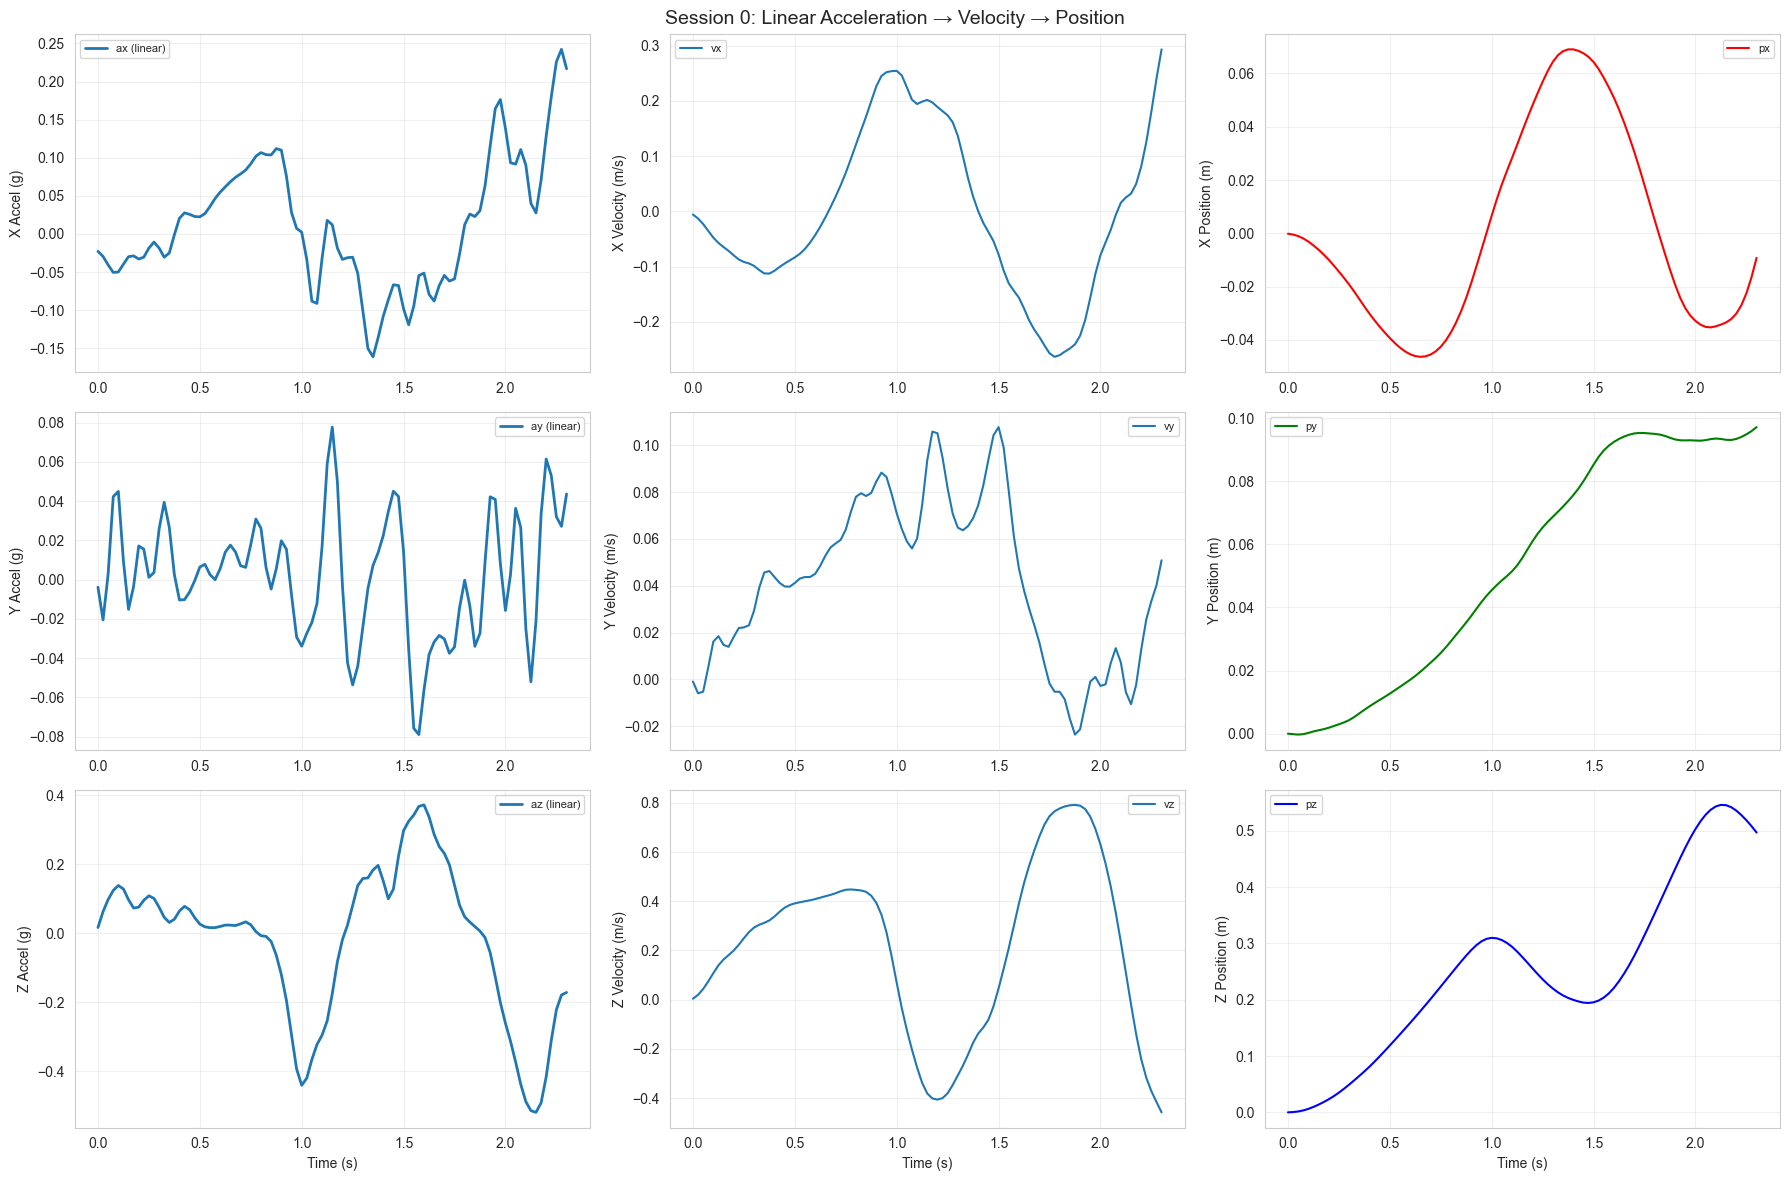

In [152]:
# Create comprehensive plots
fig = plt.figure(figsize=(18, 12))

# Create time axis from sample indices
time_axis = np.arange(len(result)) / 40.0  # 40 Hz sample rate

# 1. Acceleration (linear acceleration - gravity already removed)
ax1 = plt.subplot(3, 3, 1)
ax1.plot(time_axis, result['ax'], label='ax (linear)', linewidth=2)
ax1.set_ylabel('X Accel (g)')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(3, 3, 4)
ax2.plot(time_axis, result['ay'], label='ay (linear)', linewidth=2)
ax2.set_ylabel('Y Accel (g)')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

ax3 = plt.subplot(3, 3, 7)
ax3.plot(time_axis, result['az'], label='az (linear)', linewidth=2)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Z Accel (g)')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# 2. Velocity
ax4 = plt.subplot(3, 3, 2)
ax4.plot(time_axis, result['vx'], label='vx')
ax4.set_ylabel('X Velocity (m/s)')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

ax5 = plt.subplot(3, 3, 5)
ax5.plot(time_axis, result['vy'], label='vy')
ax5.set_ylabel('Y Velocity (m/s)')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

ax6 = plt.subplot(3, 3, 8)
ax6.plot(time_axis, result['vz'], label='vz')
ax6.set_xlabel('Time (s)')
ax6.set_ylabel('Z Velocity (m/s)')
ax6.legend(fontsize=8)
ax6.grid(True, alpha=0.3)

# 3. Position
ax7 = plt.subplot(3, 3, 3)
ax7.plot(time_axis, result['px'], label='px', color='red')
ax7.set_ylabel('X Position (m)')
ax7.legend(fontsize=8)
ax7.grid(True, alpha=0.3)

ax8 = plt.subplot(3, 3, 6)
ax8.plot(time_axis, result['py'], label='py', color='green')
ax8.set_ylabel('Y Position (m)')
ax8.legend(fontsize=8)
ax8.grid(True, alpha=0.3)

ax9 = plt.subplot(3, 3, 9)
ax9.plot(time_axis, result['pz'], label='pz', color='blue')
ax9.set_xlabel('Time (s)')
ax9.set_ylabel('Z Position (m)')
ax9.legend(fontsize=8)
ax9.grid(True, alpha=0.3)

plt.suptitle(f'Session {sample_session_id}: Linear Acceleration → Velocity → Position', fontsize=14)
plt.tight_layout()
plt.show()

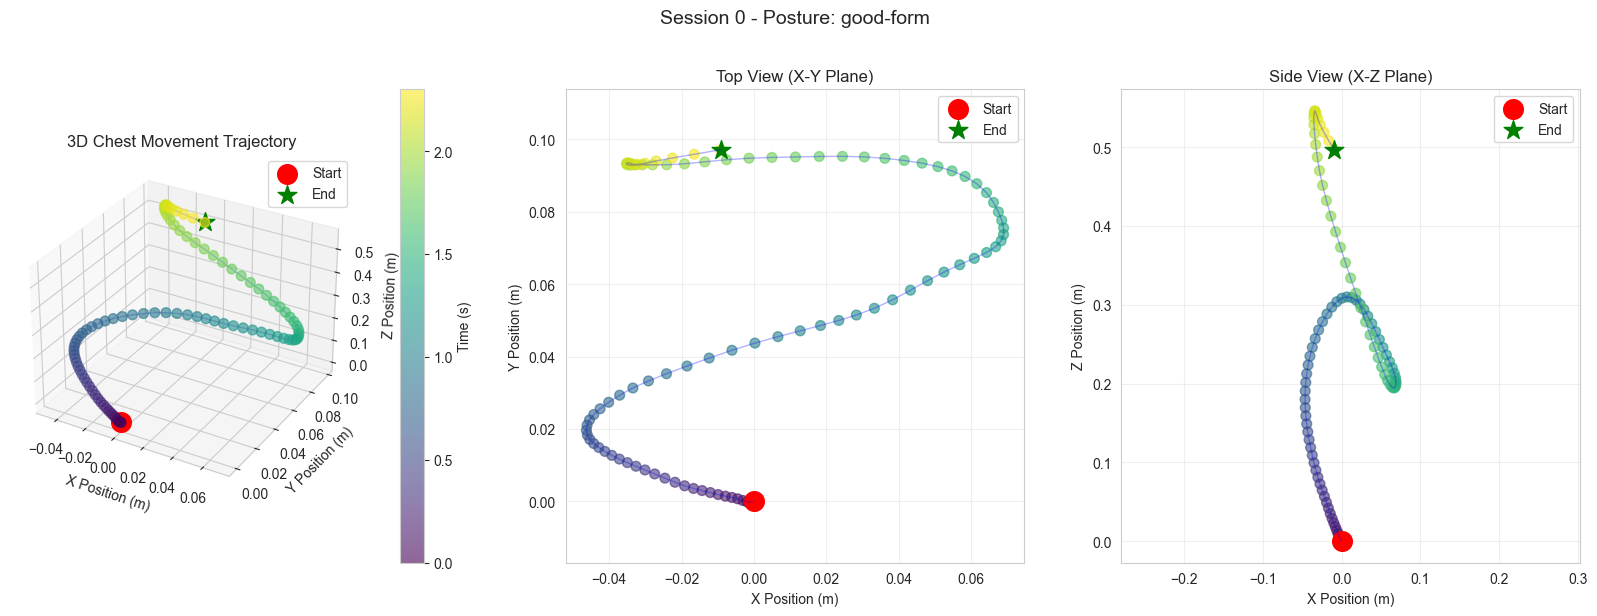

In [153]:
# Create 3D trajectory plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 6))

# Create time axis for colormap
time_axis = np.arange(len(result)) / 40.0

# 3D trajectory
ax1 = fig.add_subplot(131, projection='3d')
scatter = ax1.scatter(result['px'], result['py'], result['pz'], 
                     c=time_axis, cmap='viridis', 
                     s=50, alpha=0.6)
ax1.plot(result['px'], result['py'], result['pz'], 'b-', alpha=0.3, linewidth=1)
ax1.scatter([0], [0], [0], color='red', s=200, marker='o', label='Start')
ax1.scatter([result['px'].iloc[-1]], [result['py'].iloc[-1]], [result['pz'].iloc[-1]], 
           color='green', s=200, marker='*', label='End')
ax1.set_xlabel('X Position (m)')
ax1.set_ylabel('Y Position (m)')
ax1.set_zlabel('Z Position (m)')
ax1.set_title('3D Chest Movement Trajectory')
ax1.legend()
plt.colorbar(scatter, ax=ax1, label='Time (s)', pad=0.1)

# 2D projections - Top view (X-Y)
ax2 = fig.add_subplot(132)
scatter2 = ax2.scatter(result['px'], result['py'], c=time_axis, 
                      cmap='viridis', s=50, alpha=0.6)
ax2.plot(result['px'], result['py'], 'b-', alpha=0.3, linewidth=1)
ax2.scatter([0], [0], color='red', s=200, marker='o', label='Start')
ax2.scatter([result['px'].iloc[-1]], [result['py'].iloc[-1]], 
           color='green', s=200, marker='*', label='End')
ax2.set_xlabel('X Position (m)')
ax2.set_ylabel('Y Position (m)')
ax2.set_title('Top View (X-Y Plane)')
ax2.grid(True, alpha=0.3)
ax2.axis('equal')
ax2.legend()

# X-Z projection (side view)
ax3 = fig.add_subplot(133)
scatter3 = ax3.scatter(result['px'], result['pz'], c=time_axis, 
                      cmap='viridis', s=50, alpha=0.6)
ax3.plot(result['px'], result['pz'], 'b-', alpha=0.3, linewidth=1)
ax3.scatter([0], [0], color='red', s=200, marker='o', label='Start')
ax3.scatter([result['px'].iloc[-1]], [result['pz'].iloc[-1]], 
           color='green', s=200, marker='*', label='End')
ax3.set_xlabel('X Position (m)')
ax3.set_ylabel('Z Position (m)')
ax3.set_title('Side View (X-Z Plane)')
ax3.grid(True, alpha=0.3)
ax3.axis('equal')
ax3.legend()

plt.suptitle(f'Session {sample_session_id} - Posture: {sample_data["posture_label"].iloc[0]}', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Compare Multiple Sessions

Let's visualize trajectories from different posture types to see if there are distinguishable patterns.

Comparing 4 posture types:
  - good-form: session 0
  - hips-sagging: session 75
  - hips-high: session 95
  - partial-rom: session 116


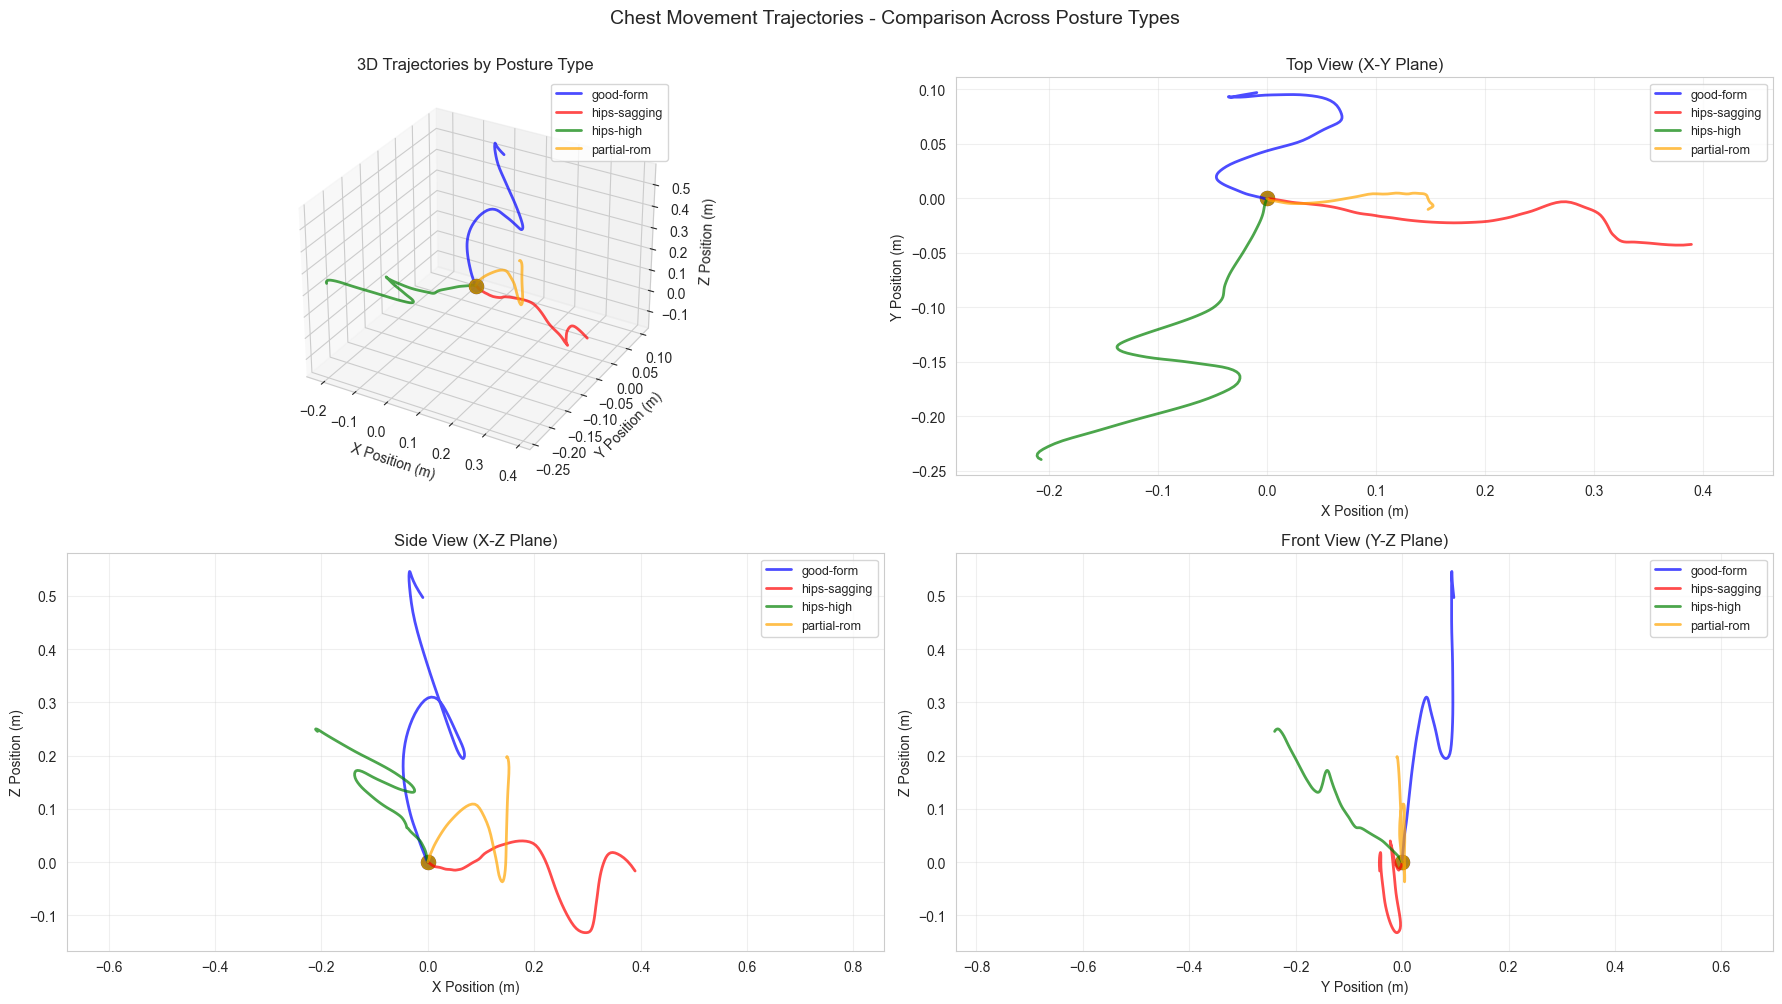


Note: All trajectories start at origin (0, 0, 0). Drift is expected due to IMU integration errors.


In [154]:
# Select one session from each posture type
posture_types = df_pos['posture_label'].unique()
sessions_to_plot = []

for posture in posture_types:
    posture_sessions = df_pos[df_pos['posture_label'] == posture]['session_id'].unique()
    if len(posture_sessions) > 0:
        sessions_to_plot.append((posture_sessions[0], posture))

print(f"Comparing {len(sessions_to_plot)} posture types:")
for sid, posture in sessions_to_plot:
    print(f"  - {posture}: session {sid}")

# Create figure
fig = plt.figure(figsize=(18, 10))

# 3D plot
ax1 = fig.add_subplot(221, projection='3d')

colors = ['blue', 'red', 'green', 'orange', 'purple']
for idx, (session_id, posture) in enumerate(sessions_to_plot):
    session_data = df_pos[df_pos['session_id'] == session_id].copy()
    session_data = session_data.sort_values('sample_index').reset_index(drop=True)
    
    result = integrate_position(session_data)
    
    ax1.plot(result['px'], result['py'], result['pz'], 
            color=colors[idx % len(colors)], alpha=0.7, linewidth=2, 
            label=f'{posture}')
    ax1.scatter([0], [0], [0], color=colors[idx % len(colors)], 
               s=100, marker='o', alpha=0.5)

ax1.set_xlabel('X Position (m)')
ax1.set_ylabel('Y Position (m)')
ax1.set_zlabel('Z Position (m)')
ax1.set_title('3D Trajectories by Posture Type')
ax1.legend(fontsize=9)

# Top view (X-Y)
ax2 = fig.add_subplot(222)
for idx, (session_id, posture) in enumerate(sessions_to_plot):
    session_data = df_pos[df_pos['session_id'] == session_id].copy()
    session_data = session_data.sort_values('sample_index').reset_index(drop=True)
    
    result = integrate_position(session_data)
    
    ax2.plot(result['px'], result['py'], 
            color=colors[idx % len(colors)], alpha=0.7, linewidth=2, 
            label=f'{posture}')
    ax2.scatter([0], [0], color=colors[idx % len(colors)], 
               s=100, marker='o', alpha=0.5)

ax2.set_xlabel('X Position (m)')
ax2.set_ylabel('Y Position (m)')
ax2.set_title('Top View (X-Y Plane)')
ax2.grid(True, alpha=0.3)
ax2.axis('equal')
ax2.legend(fontsize=9)

# Side view (X-Z)
ax3 = fig.add_subplot(223)
for idx, (session_id, posture) in enumerate(sessions_to_plot):
    session_data = df_pos[df_pos['session_id'] == session_id].copy()
    session_data = session_data.sort_values('sample_index').reset_index(drop=True)
    
    result = integrate_position(session_data)
    
    ax3.plot(result['px'], result['pz'], 
            color=colors[idx % len(colors)], alpha=0.7, linewidth=2, 
            label=f'{posture}')
    ax3.scatter([0], [0], color=colors[idx % len(colors)], 
               s=100, marker='o', alpha=0.5)

ax3.set_xlabel('X Position (m)')
ax3.set_ylabel('Z Position (m)')
ax3.set_title('Side View (X-Z Plane)')
ax3.grid(True, alpha=0.3)
ax3.axis('equal')
ax3.legend(fontsize=9)

# Front view (Y-Z)
ax4 = fig.add_subplot(224)
for idx, (session_id, posture) in enumerate(sessions_to_plot):
    session_data = df_pos[df_pos['session_id'] == session_id].copy()
    session_data = session_data.sort_values('sample_index').reset_index(drop=True)
    
    result = integrate_position(session_data)
    
    ax4.plot(result['py'], result['pz'], 
            color=colors[idx % len(colors)], alpha=0.7, linewidth=2, 
            label=f'{posture}')
    ax4.scatter([0], [0], color=colors[idx % len(colors)], 
               s=100, marker='o', alpha=0.5)

ax4.set_xlabel('Y Position (m)')
ax4.set_ylabel('Z Position (m)')
ax4.set_title('Front View (Y-Z Plane)')
ax4.grid(True, alpha=0.3)
ax4.axis('equal')
ax4.legend(fontsize=9)

plt.suptitle('Chest Movement Trajectories - Comparison Across Posture Types', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print("\nNote: All trajectories start at origin (0, 0, 0). Drift is expected due to IMU integration errors.")